# Dataworth with Freyberg Pilot Points Model

Here we are going to investigate the sources of forecast uncertainty as well as the worth of observations to reduce forecast uncertainty.  This is essentially the same workflow as used with the ``freyberg_zone_dataworth`` excersize.  Important things to remember:
- FOSM doesn't require values for observations, parameters or forecast.  We do need sensitivities between the quantities and estimates of prior uncertainties for parameters and observtion noise.  
- 

In [1]:
%matplotlib inline
import os
import sys
sys.path.append("..")
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
import pyemu

In [2]:
import freyberg_setup as fs
fs.setup_pest_pp()
working_dir = fs.WORKING_DIR_PP
pst_name = fs.PST_NAME_PP

['.DS_Store', 'botm.ref', 'extract_zone_array.py', 'forecasts_true.csv', 'freyberg.bas', 'freyberg.dbf', 'freyberg.dis', 'freyberg.hds', 'freyberg.heads', 'freyberg.heads_potobs.ins', 'freyberg.hyd', 'freyberg.list', 'freyberg.locations', 'freyberg.mpbas', 'freyberg.mpenpt', 'freyberg.mplist', 'freyberg.mpnam', 'freyberg.mppthln', 'freyberg.mpsim', 'freyberg.oc', 'freyberg.pcg', 'freyberg.rivflux', 'freyberg.shp', 'freyberg.shx', 'freyberg.travel', 'freyberg.truth.lpf', 'freyberg.truth.nam', 'freyberg.truth.rch', 'freyberg.truth.riv', 'freyberg.truth.wel', 'hk.truth.ref', 'hk.zones', 'ibound.ref', 'kzone.ref', 'mpath.in', 'obs_loc.csv', 'potobs_group.csv', 'Process_output.py', 'run_true_model.py', 'strt.ref', 'Weights_and_best_PHI.xlsx']

changing model workspace...
   freyberg_pp
FloPy is using the following executable to run the model: /Users/jwhite/Dev/GW1876/activities/freyberg_pilot_points_dataworth/freyberg_pp/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GE

In [3]:
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
par = pst.parameter_data
par.loc[par.parnme.apply(lambda x: x.startswith("w")),"partrans"] = "fixed"
pst.control_data.noptmax = -1
pst.write(os.path.join(working_dir,pst_name))


In [4]:
os.chdir(working_dir)
pyemu.helpers.start_slaves('.',"pestpp",pst_name,num_slaves=15,master_dir=".")
os.chdir("..")

master:pestpp freyberg_pp.pst /h :4004 in .
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_0
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_1
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_2
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_3
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_4
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_5
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_6
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_7
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_8
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_9
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_10
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_11
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_12
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_13
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_14


In [5]:
sc = pyemu.Schur(os.path.join(working_dir,pst_name.replace(".pst",".jcb")))

A quick check of which parameters are being informed by the observations during calibration:

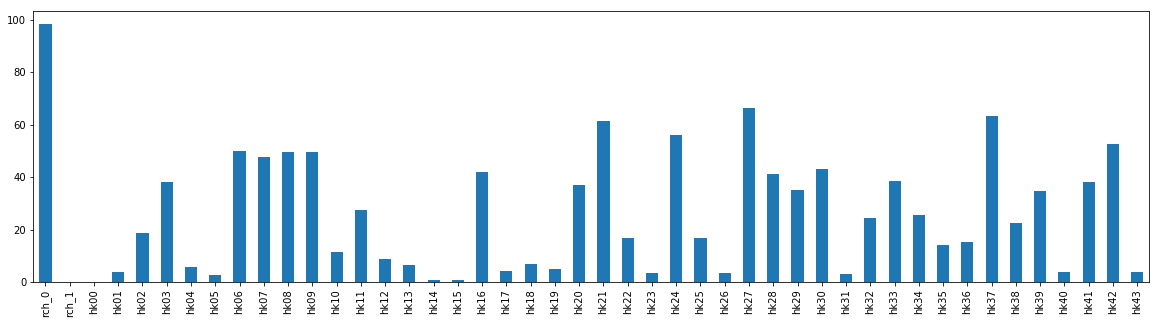

In [6]:
fig = plt.figure(figsize=(20,5))
ax = plt.subplot(111)
sc.get_parameter_summary().percent_reduction.plot(kind="bar",ax=ax)

## Parameter contribution analysis

We are going to use the ``Schur.get_par_contribution()`` method. It calculates the *decrease* in forecast uncertainty resulting for hypothetical "perfect knowledge" (no uncertainty) of arbitrary groups of parameters. If you don't pass any arguments, then it tests each parameter independently:

In [7]:
df_pc = sc.get_par_contribution()


In [8]:
df_pc = 100.0 * (1.0 - df_pc / df_pc.loc["base",:])

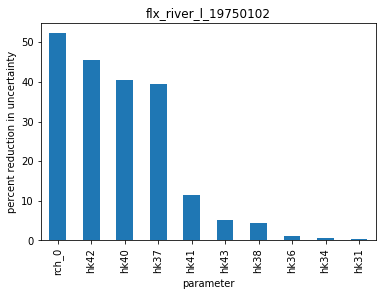

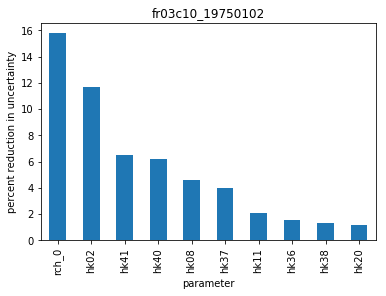

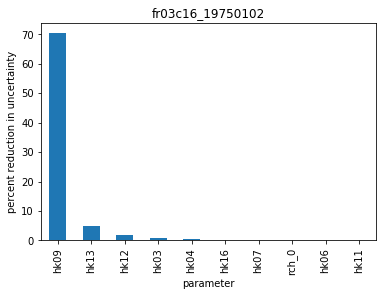

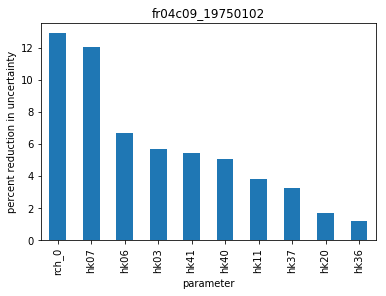

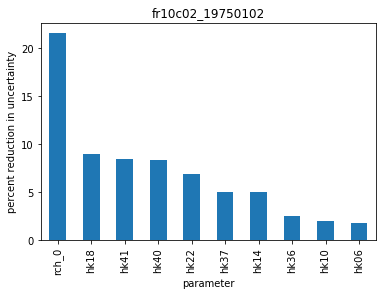

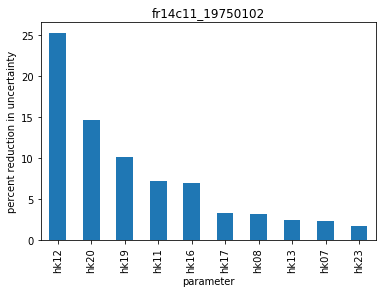

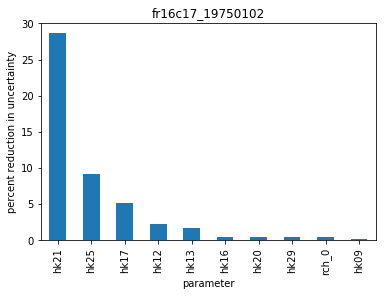

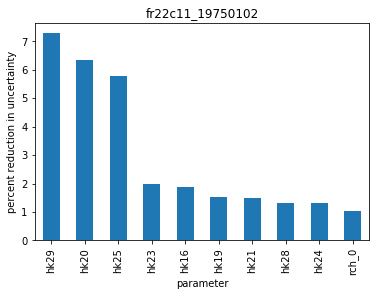

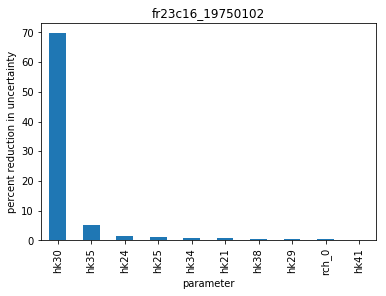

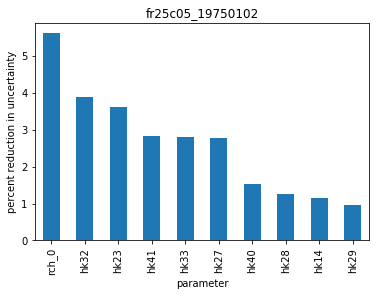

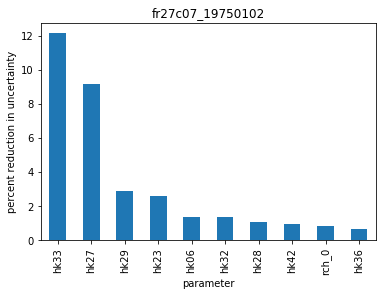

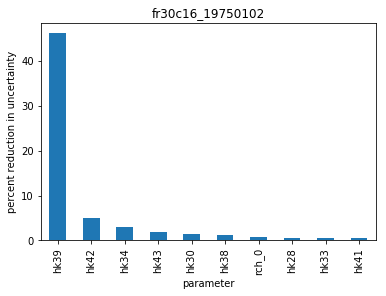

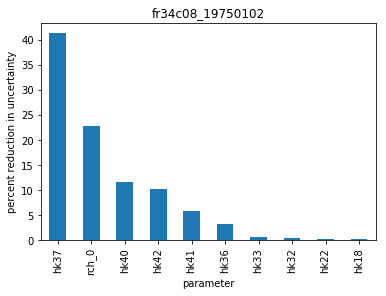

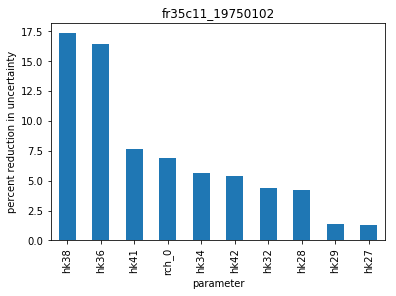

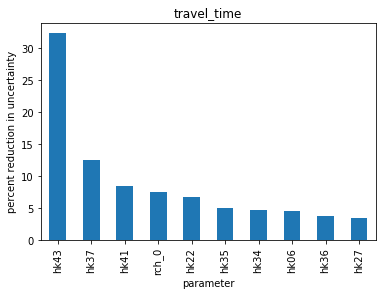

In [9]:
for forecast in df_pc.columns:
    ax = df_pc.sort_values(by=forecast,ascending=False).loc[:,forecast].iloc[:10].plot(kind="bar")
    ax.set_title(forecast)
    ax.set_ylabel("percent reduction in uncertainty")
    ax.set_xlabel("parameter")
    plt.show()

We see a mixture of HK pilot points, recharge, and well pumping rates...so we see that each forecast depends on (potentailly) difference combinations of parameters.  Does this mean we can still make a model that makes several kinds of forecasts???

## Observation worth

Let's see what observations are most important to the forecasts.  We will start be investigating the value of the existing observations using the ``Schur.get_removed_obs_importance()`` method.  It calculates the *increase* in forecast uncertainty that happens if we lose each existing observation. We will start with the existing observations:

In [10]:
df_rm = sc.get_removed_obs_importance()
df_rm

,flx_river_l_19750102,fr03c10_19750102,fr03c16_19750102,fr04c09_19750102,fr10c02_19750102,fr14c11_19750102,fr16c17_19750102,fr22c11_19750102,fr23c16_19750102,fr25c05_19750102,fr27c07_19750102,fr30c16_19750102,fr34c08_19750102,fr35c11_19750102,travel_time
base,1404.096287,0.018379,0.014243,0.029419,0.047620,0.034239,0.019306,0.018031,0.013462,0.032849,0.027304,0.014144,0.030903,0.031354,2.880462e+07
cr04c09_19700102,1404.133085,0.026512,0.014245,0.183574,0.047621,0.034701,0.019313,0.018032,0.013463,0.032858,0.027341,0.014144,0.030910,0.031362,2.888798e+07
cr14c11_19700102,1404.330774,0.018900,0.014258,0.030582,0.047942,0.215332,0.019391,0.019133,0.013499,0.032972,0.027570,0.014145,0.030917,0.031372,2.894224e+07
cr30c16_19700102,1410.693692,0.018492,0.014244,0.029586,0.047898,0.034249,0.019306,0.018032,0.013783,0.033083,0.027431,0.037219,0.030936,0.031359,4.810725e+07
cr34c08_19700102,1706.901696,0.018433,0.014244,0.029478,0.048002,0.034250,0.019309,0.018033,0.013472,0.032872,0.027329,0.014155,0.561935,0.069899,2.971408e+07
cr10c02_19700102,1404.354920,0.018519,0.014247,0.031663,2.115890,0.034308,0.019306,0.018187,0.013463,0.033130,0.027895,0.014144,0.030904,0.031417,2.894450e+07
cr03c16_19700102,1404.358631,0.018395,0.035704,0.029944,0.047713,0.034260,0.019526,0.018034,0.013467,0.032853,0.027304,0.014144,0.030905,0.031355,2.880464e+07
cr03c10_19700102,1404.125279,0.101200,0.014267,0.029420,0.047875,0.034364,0.019307,0.018035,0.013463,0.032867,0.027324,0.014144,0.030908,0.031357,2.882897e+07
flx_river_l_19700102,2167.243624,0.154767,0.014872,0.210179,0.601188,0.053111,0.022534,0.060325,0.014794,0.371902,0.251640,0.016048,0.134243,0.051833,3.811759e+07
cr25c05_19700102,1404.828807,0.018383,0.014243,0.029476,0.048305,0.034392,0.019309,0.018089,0.013493,0.935947,0.027727,0.014153,0.030981,0.031364,2.962268e+07


In [11]:
df_rm = 100.0 * (1.0 - df_rm.loc["base",:] / df_rm)

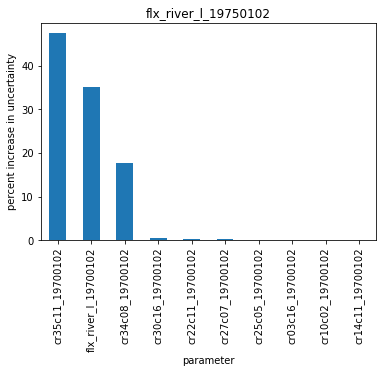

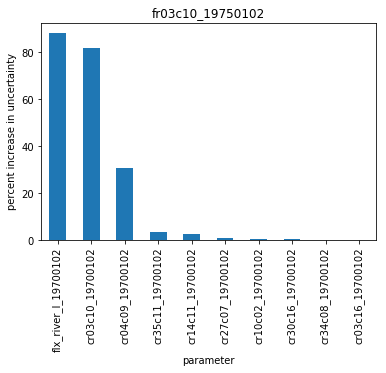

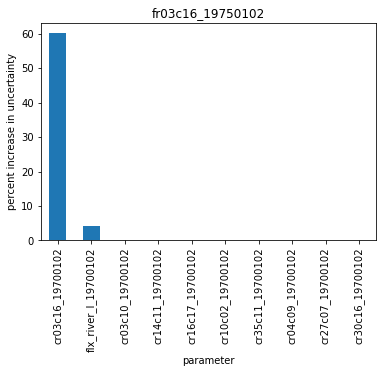

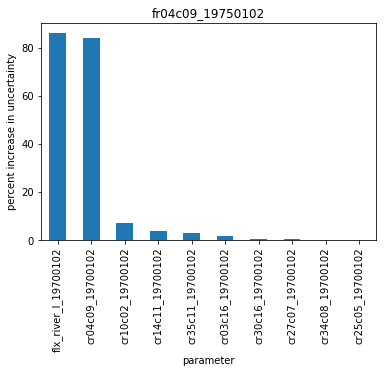

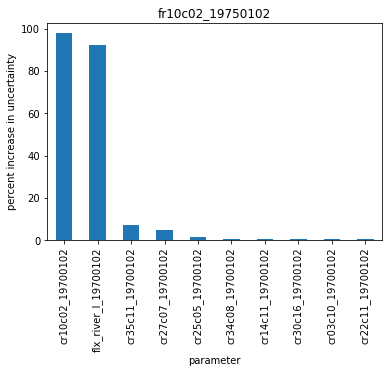

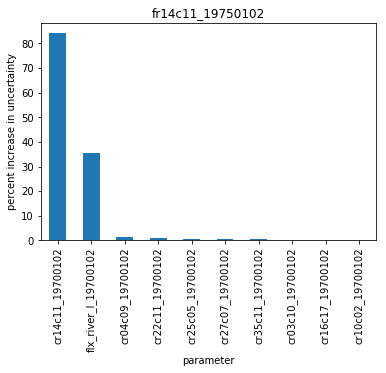

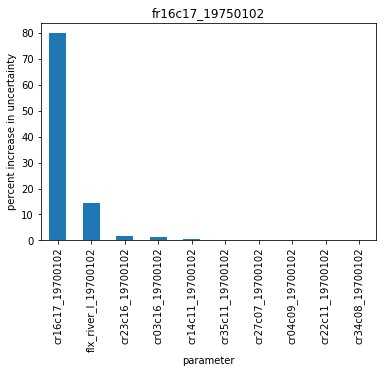

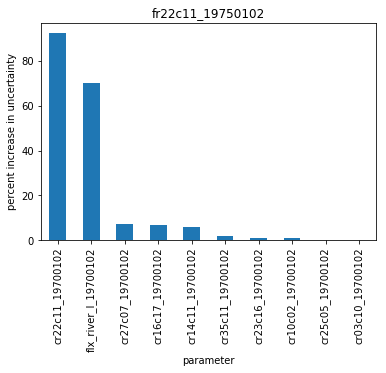

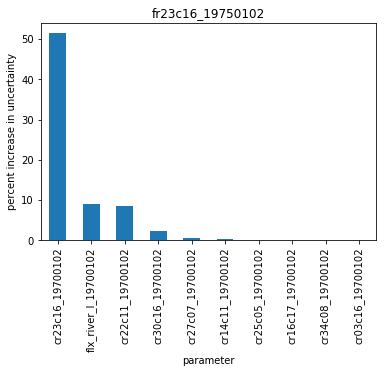

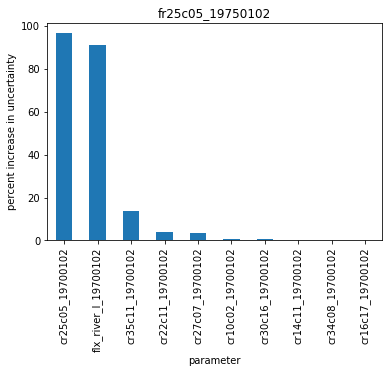

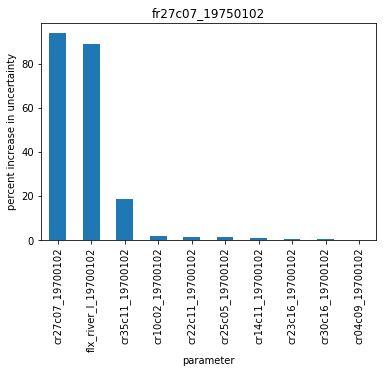

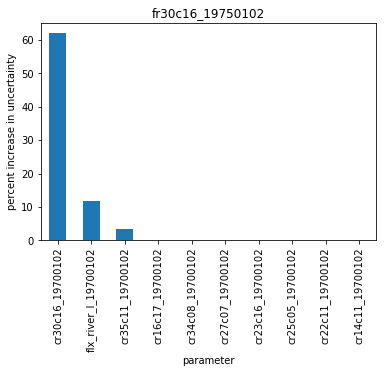

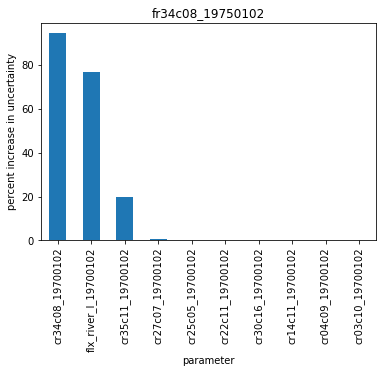

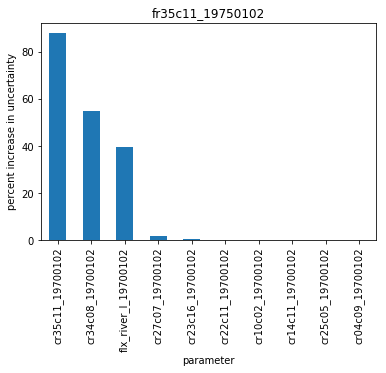

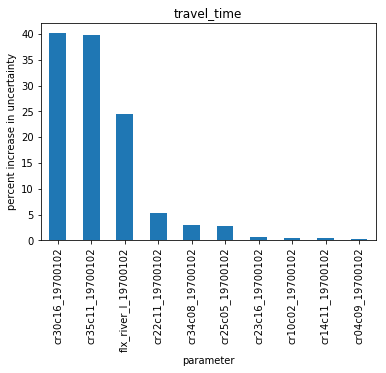

In [12]:
for forecast in df_rm.columns:
    ax = df_rm.sort_values(by=forecast,ascending=False).loc[:,forecast].iloc[:10].plot(kind="bar")
    ax.set_title(forecast)
    ax.set_ylabel("percent increase in uncertainty")
    ax.set_xlabel("parameter")
    plt.show()

### Estimating the value of yet-to-be-collected observations

Using the assumptions of FOSM, we can also calculate the value of observations we don't have yet!  Black magic!  Not really, we carried these possible data locations as ``observations`` in the control file - this means each one has a row in the jacobian (just like any other output of interest).  If we then assume some value of measurement noise (a non-zero weight in the control file), we can run a hypothetical "calibration" analysis using Schur compliment.  Remember, FOSM doesn't care about actual values of parameters, observations, or forecasts, only sensitivities...

In pyemu, the ``Schur.get_added_obs_importance()`` method calculates the *decrease* in uncertainty resulting for having new obsevations during calibration.  It accepts an optional argument ``obslist_dict`` which is a python dictionary of groups of new observations to test.  Here we will test the value of having the water level in each unmeasured model cell.  Then we can make maps of where to collect new data...these calculations take a little while to run because we are repeatedly calculating the entire FOSM process for each new observation location 

In [13]:
pobs_names = [o for o in sc.pst.obs_names if o.startswith("pr") and "19700102" in o]
df_ad = sc.get_added_obs_importance(obslist_dict={oname:oname for oname in pobs_names},
                                base_obslist=sc.pst.nnz_obs_names,reset_zero_weight=True)

In [14]:
df_ad.min()

flx_river_l_19750102    1.299542e+03
fr03c10_19750102        1.741462e-02
fr03c16_19750102        1.204368e-02
fr04c09_19750102        2.628535e-02
fr10c02_19750102        4.155743e-02
fr14c11_19750102        2.629154e-02
fr16c17_19750102        1.782311e-02
fr22c11_19750102        1.719052e-02
fr23c16_19750102        1.103572e-02
fr25c05_19750102        2.996263e-02
fr27c07_19750102        2.625537e-02
fr30c16_19750102        1.159035e-02
fr34c08_19750102        2.935146e-02
fr35c11_19750102        2.738724e-02
travel_time             2.395841e+07
dtype: float64

In [15]:
df_ad.max()

flx_river_l_19750102    1.404096e+03
fr03c10_19750102        1.837864e-02
fr03c16_19750102        1.424306e-02
fr04c09_19750102        2.941907e-02
fr10c02_19750102        4.761953e-02
fr14c11_19750102        3.423853e-02
fr16c17_19750102        1.930559e-02
fr22c11_19750102        1.803124e-02
fr23c16_19750102        1.346216e-02
fr25c05_19750102        3.284947e-02
fr27c07_19750102        2.730426e-02
fr30c16_19750102        1.414400e-02
fr34c08_19750102        3.090348e-02
fr35c11_19750102        3.135352e-02
travel_time             2.880462e+07
dtype: float64

In [16]:
# just a helper function to make maps of data worth
m = flopy.modflow.Modflow.load(fs.MODEL_NAM,model_ws=working_dir)
obs = pst.observation_data
hobs = obs.loc[obs.obgnme=="calhead",:].copy()
hobs.loc[:,"i"] = hobs.obsnme.apply(lambda x: int(x[2:4])-1)
hobs.loc[:,"j"] = hobs.obsnme.apply(lambda x: int(x.split('_')[0].split('c')[-1])-1)
hobs.loc[:,"x"] = m.sr.xcentergrid[hobs.i,hobs.j]
hobs.loc[:,"y"] = m.sr.ycentergrid[hobs.i,hobs.j]
wdata = pd.DataFrame.from_records(m.wel.stress_period_data[0])
wdata.loc[:,"x"] = m.sr.xcentergrid[wdata.i,wdata.j]
wdata.loc[:,"y"] = m.sr.ycentergrid[wdata.i,wdata.j]
def plot_added_worth(df):
    df_base = df.loc["base",:]
    df_frac = 100.0 * (1.0 - (df / df_base))
    df_frac = df_frac.loc[pobs_names,:]
    df_frac.loc[:,"i"] = df_frac.index.map(lambda x: int(x[2:4])-1)
    df_frac.loc[:,"j"] = df_frac.index.map(lambda x: int(x[5:7])-1)
    #print(df_frac.)
    for forecast in sc.pst.forecast_names:
        print(forecast)
        arr = np.zeros((m.nrow,m.ncol)) - 1
        arr[df_frac.i,df_frac.j] = df_frac.loc[:,forecast]
        arr = np.ma.masked_where(arr < 0.0 ,arr)
        fig = plt.figure(figsize=(12,10))
        
        ax = plt.subplot(111,aspect="equal")
        c = ax.pcolormesh(m.sr.xedge,m.sr.yedge,arr,alpha=0.75)
        plt.colorbar(c)
        if forecast.startswith("fr"):
            i = int(forecast[2:4]) - 1
            j = int(forecast.split('_')[0].split('c')[-1]) - 1
            x,y = m.sr.xcentergrid[i,j],m.sr.ycentergrid[i,j]
            ax.scatter([x],[y],marker='o',color='r',s=150)
            #ax2.scatter([x],[y],marker='o',color='r',s=150)    
        ax.scatter(hobs.x,hobs.y,marker='x',s=100,color='y')
        ax.scatter(wdata.x,wdata.y,marker='*',s=100,color='m')
        ax.set_title(forecast)
        plt.show()
        plt.close(fig)
    

Now we are going to plot the worth (reduction in uncertainty) of a single, new water level measurement for each forecast (forecast name is the title of each plot). So these plots show us where to go collect new data to reduce forecast uncertainty as much as possible...red circles show the forecast (for water level forecasts), yellow X's are the locations of existing water levels, purple stars mark pumping well locations (pumping rates are treated as uncertain!)

fr03c10_19750102


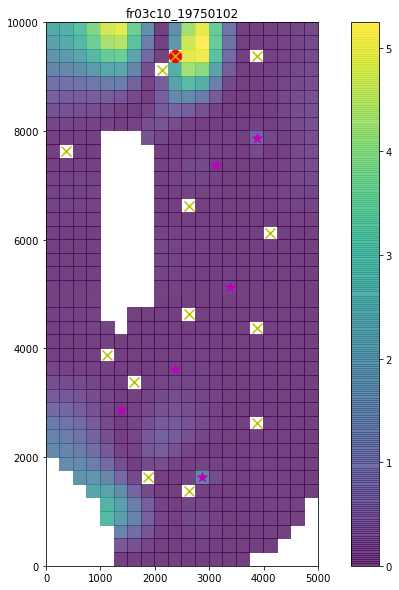

fr03c16_19750102


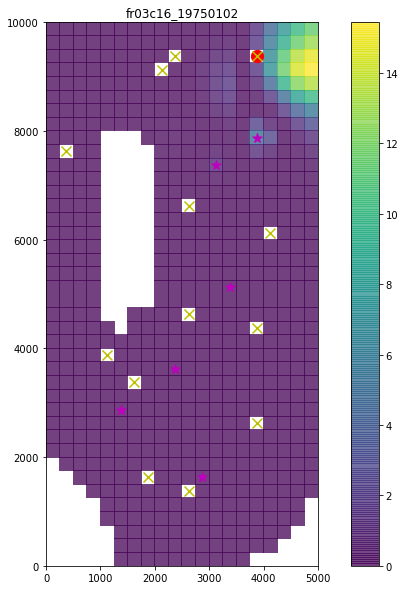

fr04c09_19750102


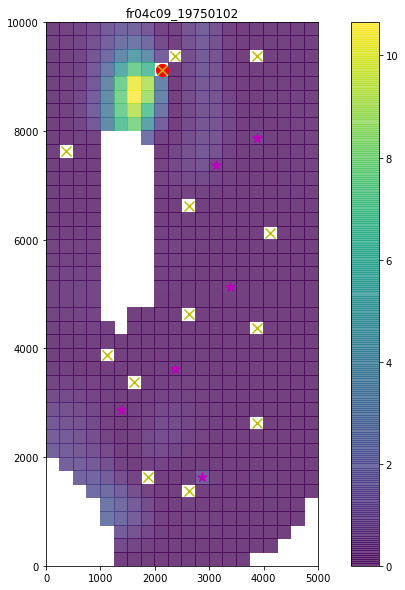

fr10c02_19750102


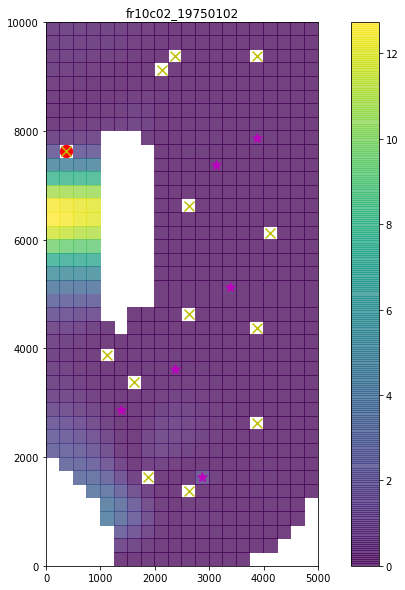

fr14c11_19750102


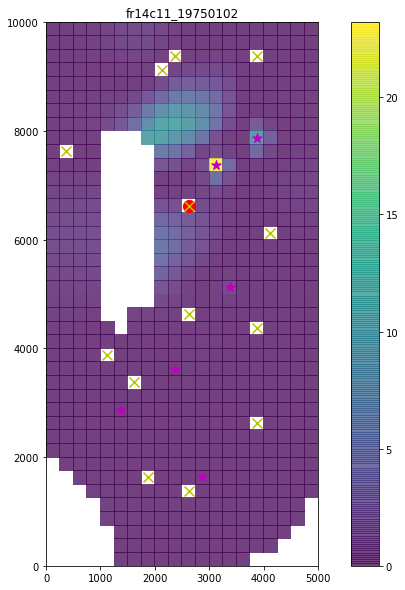

fr16c17_19750102


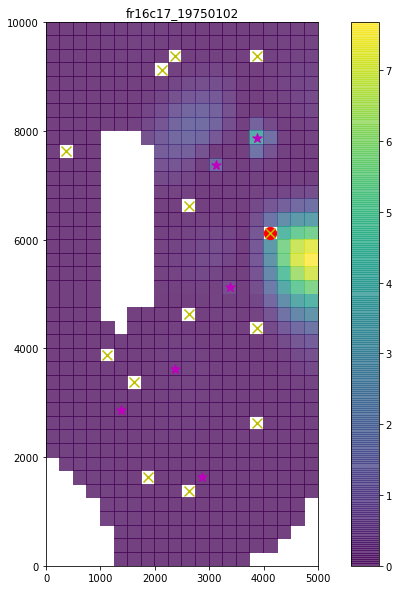

fr22c11_19750102


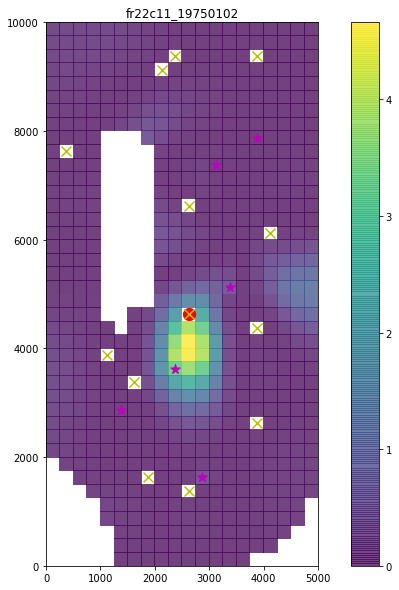

fr23c16_19750102


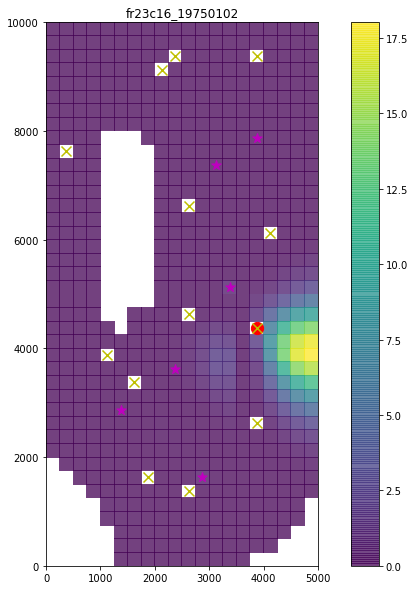

fr25c05_19750102


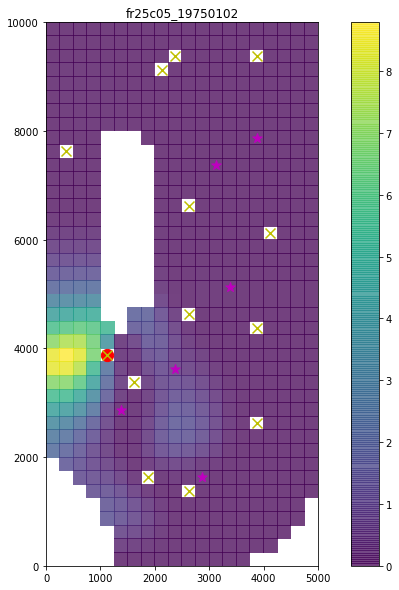

fr27c07_19750102


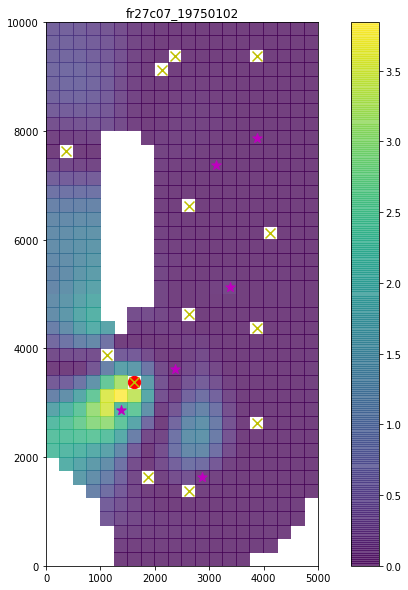

fr30c16_19750102


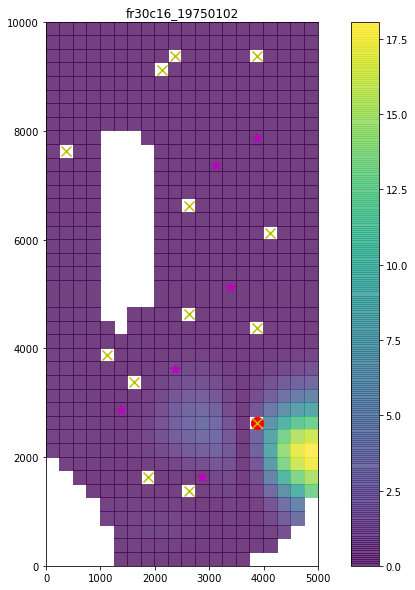

fr34c08_19750102


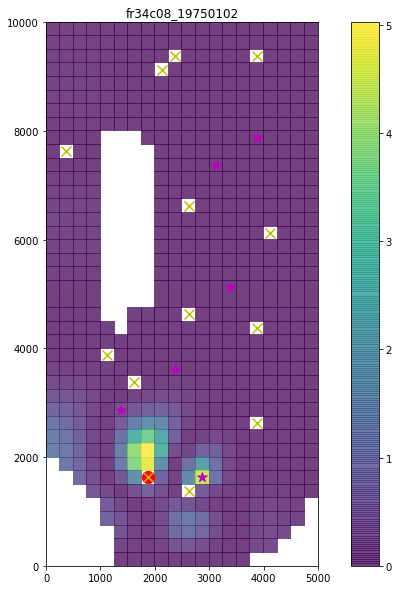

fr35c11_19750102


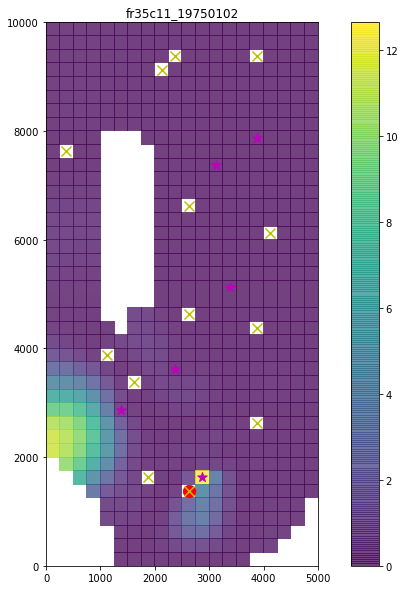

flx_river_l_19750102


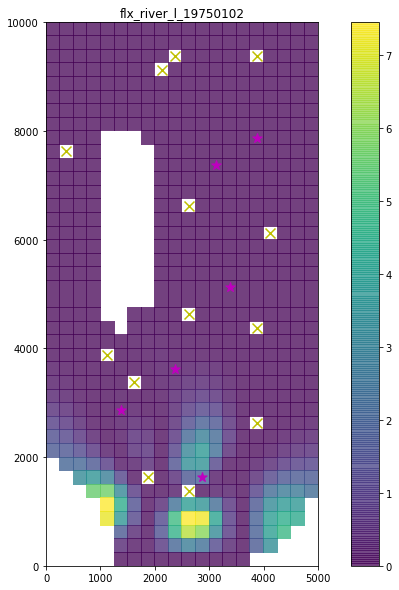

travel_time


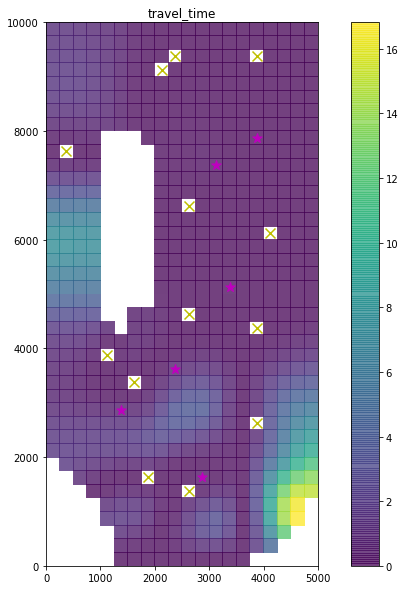

In [17]:
plot_added_worth(df_ad)

Ok, so those are cool.  And, unlike the zoned-parameterization dataworth, these make sense from a physical interpretation standpoint

Let's explore what happens when we use a full covariance prior

In [18]:
v = pyemu.geostats.ExpVario(contribution=1.0,a=2500.0)
gs = pyemu.geostats.GeoStruct(variograms=[v])
cov = pyemu.helpers.pilotpoint_prior_builder(sc.pst,
                            struct_dict={gs:os.path.join(working_dir,"hkpp.dat.tpl")})

/Users/jwhite/Dev/python/pyemu/pyemu/utils/helpers.py:50: UserWarning: 'pilotpoint_prior_builder' has been renamed to 'geostatistical_prior_builder'
  "'geostatistical_prior_builder'")


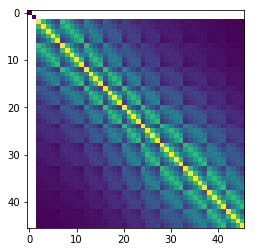

In [19]:
x = np.ma.masked_where(cov.x==0,cov.x)
plt.imshow(x)

In [20]:
sc_full = pyemu.Schur(jco=sc.jco,pst=sc.pst,parcov=cov,forecasts=sc.forecasts,verbose=True)

2017-09-05 13:40:37.576942 starting: pre-loading base components
2017-09-05 13:40:37.577248 starting: loading obscov
2017-09-05 13:40:37.776067 finished: loading obscov took: 0:00:00.198819
2017-09-05 13:40:37.776166 starting: loading forecasts
2017-09-05 13:40:37.783414 finished: loading forecasts took: 0:00:00.007248
2017-09-05 13:40:37.783473 forecast names: fr03c10_19750102,fr03c16_19750102,fr04c09_19750102,fr10c02_19750102,fr14c11_19750102,fr16c17_19750102,fr22c11_19750102,fr23c16_19750102,fr25c05_19750102,fr27c07_19750102,fr30c16_19750102,fr34c08_19750102,fr35c11_19750102,flx_river_l_19750102,travel_time
2017-09-05 13:40:37.783664 finished: pre-loading base components took: 0:00:00.206722
2017-09-05 13:40:37.783719 starting: dropping prior information
2017-09-05 13:40:37.784336 starting: removing 0 prior info from jco, pst, and obs cov
2017-09-05 13:40:37.785992 finished: removing 0 prior info from jco, pst, and obs cov took: 0:00:00.001656
2017-09-05 13:40:37.786057 finished: dr

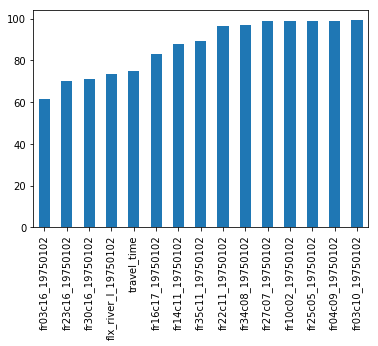

In [21]:
sc.get_forecast_summary().sort_values(by='percent_reduction').percent_reduction.plot(kind="bar")

In [22]:
df_full = sc_full.get_forecast_summary()
df_full.loc[:,"full"] = df_full.percent_reduction
df_full.loc[:,"diag"] = sc.get_forecast_summary().percent_reduction

2017-09-05 13:40:38.009791 starting: propagating prior to predictions
2017-09-05 13:40:38.010483 finished: propagating prior to predictions took: 0:00:00.000692
2017-09-05 13:40:38.010665 starting: propagating posterior to predictions
2017-09-05 13:40:38.011004 starting: Schur's complement
2017-09-05 13:40:38.011468 starting: xtqx
2017-09-05 13:40:39.299827 finished: xtqx took: 0:00:01.288359
2017-09-05 13:40:39.300512 finished: Schur's complement took: 0:00:01.289508
2017-09-05 13:40:39.300900 finished: propagating posterior to predictions took: 0:00:01.290235


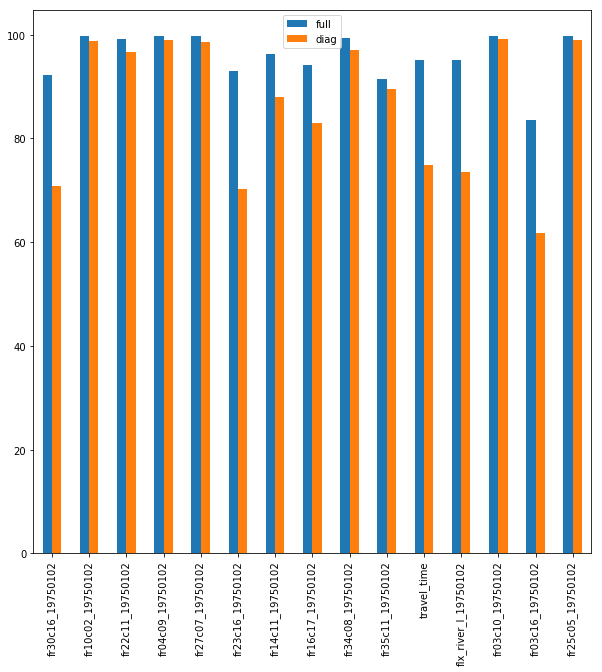

In [23]:
df_full.loc[:,["full","diag"]].plot(kind="bar",figsize=(10,10))

Why did percent reduction increase for all forecasts increase???

In [24]:
df_full.prior_var

fr30c16_19750102        1.471837e-01
fr10c02_19750102        2.607196e+01
fr22c11_19750102        1.760011e+00
fr04c09_19750102        1.105415e+01
fr27c07_19750102        1.007493e+01
fr23c16_19750102        1.324689e-01
fr14c11_19750102        6.869746e-01
fr16c17_19750102        2.760667e-01
fr34c08_19750102        3.982722e+00
fr35c11_19750102        3.028776e-01
travel_time             4.816976e+08
flx_river_l_19750102    1.461269e+04
fr03c10_19750102        8.541809e+00
fr03c16_19750102        6.437394e-02
fr25c05_19750102        1.621692e+01
Name: prior_var, dtype: float64

In [25]:
sc.get_forecast_summary().prior_var

fr30c16_19750102        4.860117e-02
fr10c02_19750102        4.285210e+00
fr22c11_19750102        5.481131e-01
fr04c09_19750102        2.745582e+00
fr27c07_19750102        2.058207e+00
fr23c16_19750102        4.526928e-02
fr14c11_19750102        2.847725e-01
fr16c17_19750102        1.137371e-01
fr34c08_19750102        1.057399e+00
fr35c11_19750102        2.981501e-01
travel_time             1.145390e+08
flx_river_l_19750102    5.316597e+03
fr03c10_19750102        2.274138e+00
fr03c16_19750102        3.721656e-02
fr25c05_19750102        3.043277e+00
Name: prior_var, dtype: float64

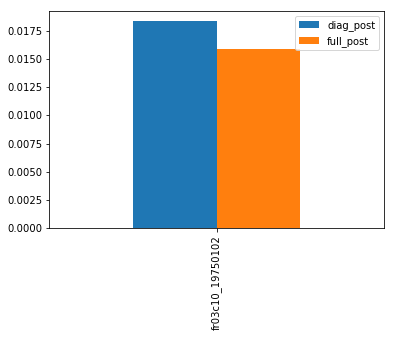

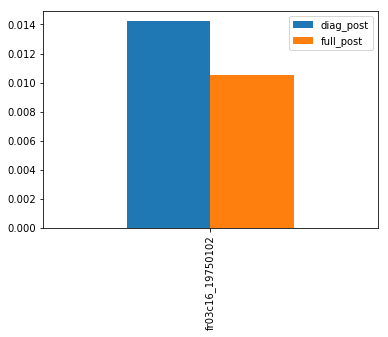

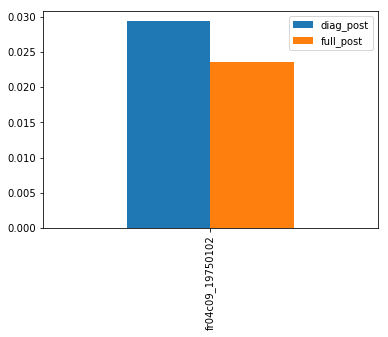

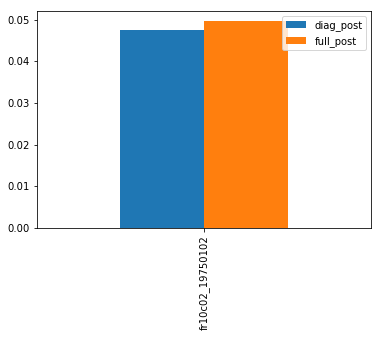

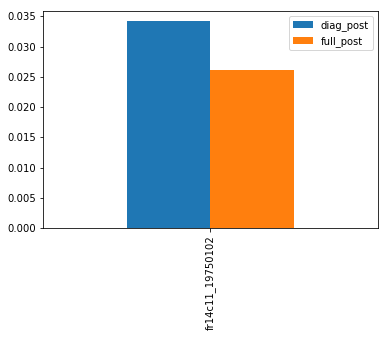

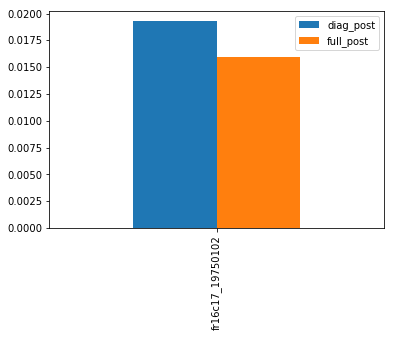

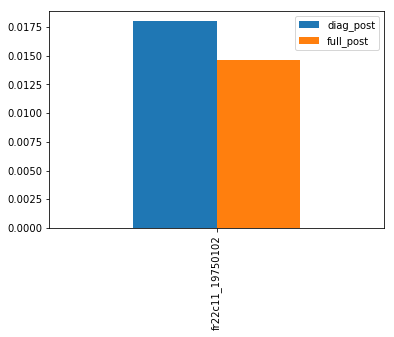

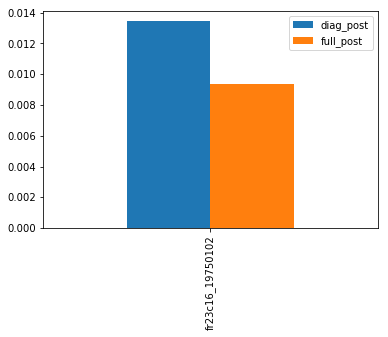

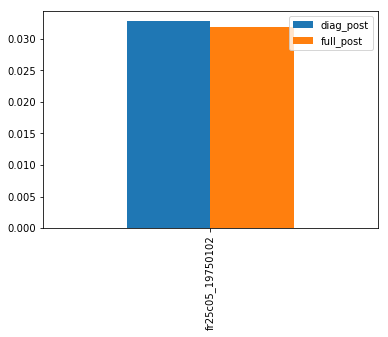

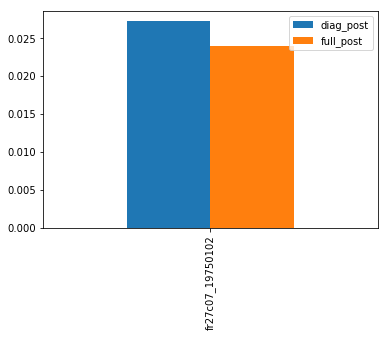

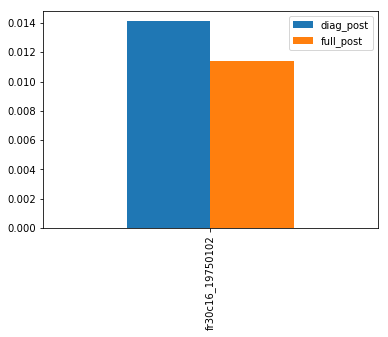

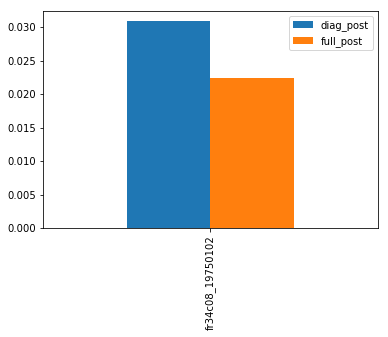

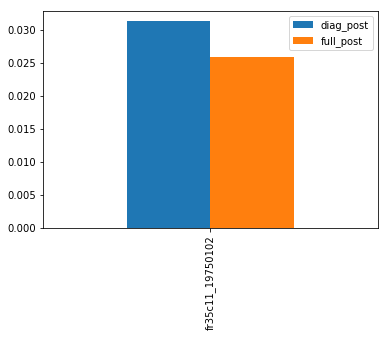

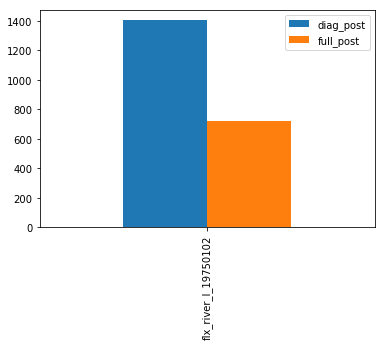

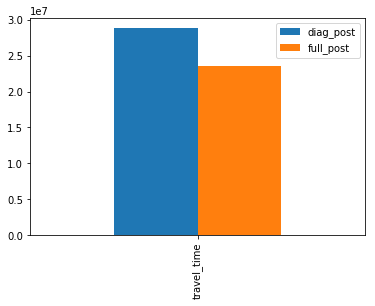

In [26]:
df_full.loc[:,"diag_post"] = sc.get_forecast_summary().post_var
df_full.loc[:,"full_post"] = df_full.post_var
for forecast in pst.forecast_names:
    df_full.loc[[forecast],["diag_post","full_post"]].plot(kind="bar")

Let's recalculate the value of possible new observations...this takes longer now that we are using a full covaraince matrix because the repeated matrix-matrix products...

In [27]:
df_full = sc_full.get_added_obs_importance(obslist_dict={oname:oname for oname in pobs_names},
                                base_obslist=sc.pst.nnz_obs_names,reset_zero_weight=True)

2017-09-05 13:40:41.951941 resetting zero weights to 1.0
2017-09-05 13:40:42.359854 starting: resetting zero weight obs in base_obslist
2017-09-05 13:40:42.372554 finished: resetting zero weight obs in base_obslist took: 0:00:00.012700
2017-09-05 13:40:42.372663 starting: resetting zero weight obs in pr11c12_19700102
2017-09-05 13:40:42.385495 finished: resetting zero weight obs in pr11c12_19700102 took: 0:00:00.012832
2017-09-05 13:40:42.385582 starting: resetting zero weight obs in pr17c17_19700102
2017-09-05 13:40:42.398012 finished: resetting zero weight obs in pr17c17_19700102 took: 0:00:00.012430
2017-09-05 13:40:42.398104 starting: resetting zero weight obs in pr35c10_19700102
2017-09-05 13:40:42.410743 finished: resetting zero weight obs in pr35c10_19700102 took: 0:00:00.012639
2017-09-05 13:40:42.410833 starting: resetting zero weight obs in pr21c13_19700102
2017-09-05 13:40:42.423724 finished: resetting zero weight obs in pr21c13_19700102 took: 0:00:00.012891
2017-09-05 13:40

2017-09-05 13:40:43.256250 starting: resetting zero weight obs in pr31c01_19700102
2017-09-05 13:40:43.272962 finished: resetting zero weight obs in pr31c01_19700102 took: 0:00:00.016712
2017-09-05 13:40:43.273066 starting: resetting zero weight obs in pr22c17_19700102
2017-09-05 13:40:43.289410 finished: resetting zero weight obs in pr22c17_19700102 took: 0:00:00.016344
2017-09-05 13:40:43.289548 starting: resetting zero weight obs in pr24c13_19700102
2017-09-05 13:40:43.305888 finished: resetting zero weight obs in pr24c13_19700102 took: 0:00:00.016340
2017-09-05 13:40:43.305998 starting: resetting zero weight obs in pr25c03_19700102
2017-09-05 13:40:43.322818 finished: resetting zero weight obs in pr25c03_19700102 took: 0:00:00.016820
2017-09-05 13:40:43.322936 starting: resetting zero weight obs in pr09c02_19700102
2017-09-05 13:40:43.338694 finished: resetting zero weight obs in pr09c02_19700102 took: 0:00:00.015758
2017-09-05 13:40:43.338788 starting: resetting zero weight obs in

2017-09-05 13:40:44.119226 finished: resetting zero weight obs in pr29c04_19700102 took: 0:00:00.018691
2017-09-05 13:40:44.119336 starting: resetting zero weight obs in pr11c19_19700102
2017-09-05 13:40:44.136515 finished: resetting zero weight obs in pr11c19_19700102 took: 0:00:00.017179
2017-09-05 13:40:44.136596 starting: resetting zero weight obs in pr38c08_19700102
2017-09-05 13:40:44.155229 finished: resetting zero weight obs in pr38c08_19700102 took: 0:00:00.018633
2017-09-05 13:40:44.155337 starting: resetting zero weight obs in pr16c04_19700102
2017-09-05 13:40:44.173842 finished: resetting zero weight obs in pr16c04_19700102 took: 0:00:00.018505
2017-09-05 13:40:44.173950 starting: resetting zero weight obs in pr13c03_19700102
2017-09-05 13:40:44.190817 finished: resetting zero weight obs in pr13c03_19700102 took: 0:00:00.016867
2017-09-05 13:40:44.190919 starting: resetting zero weight obs in pr29c18_19700102
2017-09-05 13:40:44.207730 finished: resetting zero weight obs in

2017-09-05 13:40:44.995118 finished: resetting zero weight obs in pr34c18_19700102 took: 0:00:00.024285
2017-09-05 13:40:44.995467 starting: resetting zero weight obs in pr29c01_19700102
2017-09-05 13:40:45.015436 finished: resetting zero weight obs in pr29c01_19700102 took: 0:00:00.019969
2017-09-05 13:40:45.015564 starting: resetting zero weight obs in pr39c09_19700102
2017-09-05 13:40:45.034930 finished: resetting zero weight obs in pr39c09_19700102 took: 0:00:00.019366
2017-09-05 13:40:45.035047 starting: resetting zero weight obs in pr34c11_19700102
2017-09-05 13:40:45.055310 finished: resetting zero weight obs in pr34c11_19700102 took: 0:00:00.020263
2017-09-05 13:40:45.055409 starting: resetting zero weight obs in pr12c20_19700102
2017-09-05 13:40:45.074848 finished: resetting zero weight obs in pr12c20_19700102 took: 0:00:00.019439
2017-09-05 13:40:45.074951 starting: resetting zero weight obs in pr23c18_19700102
2017-09-05 13:40:45.094644 finished: resetting zero weight obs in

2017-09-05 13:40:46.053945 starting: resetting zero weight obs in pr28c18_19700102
2017-09-05 13:40:46.077096 finished: resetting zero weight obs in pr28c18_19700102 took: 0:00:00.023151
2017-09-05 13:40:46.077193 starting: resetting zero weight obs in pr25c02_19700102
2017-09-05 13:40:46.098041 finished: resetting zero weight obs in pr25c02_19700102 took: 0:00:00.020848
2017-09-05 13:40:46.098139 starting: resetting zero weight obs in pr05c13_19700102
2017-09-05 13:40:46.119842 finished: resetting zero weight obs in pr05c13_19700102 took: 0:00:00.021703
2017-09-05 13:40:46.120179 starting: resetting zero weight obs in pr03c02_19700102
2017-09-05 13:40:46.140869 finished: resetting zero weight obs in pr03c02_19700102 took: 0:00:00.020690
2017-09-05 13:40:46.140974 starting: resetting zero weight obs in pr02c12_19700102
2017-09-05 13:40:46.162187 finished: resetting zero weight obs in pr02c12_19700102 took: 0:00:00.021213
2017-09-05 13:40:46.162290 starting: resetting zero weight obs in

2017-09-05 13:40:47.168367 starting: resetting zero weight obs in pr06c14_19700102
2017-09-05 13:40:47.192164 finished: resetting zero weight obs in pr06c14_19700102 took: 0:00:00.023797
2017-09-05 13:40:47.192457 starting: resetting zero weight obs in pr12c10_19700102
2017-09-05 13:40:47.215335 finished: resetting zero weight obs in pr12c10_19700102 took: 0:00:00.022878
2017-09-05 13:40:47.215447 starting: resetting zero weight obs in pr38c13_19700102
2017-09-05 13:40:47.238521 finished: resetting zero weight obs in pr38c13_19700102 took: 0:00:00.023074
2017-09-05 13:40:47.238646 starting: resetting zero weight obs in pr13c01_19700102
2017-09-05 13:40:47.261527 finished: resetting zero weight obs in pr13c01_19700102 took: 0:00:00.022881
2017-09-05 13:40:47.261638 starting: resetting zero weight obs in pr16c20_19700102
2017-09-05 13:40:47.282842 finished: resetting zero weight obs in pr16c20_19700102 took: 0:00:00.021204
2017-09-05 13:40:47.282964 starting: resetting zero weight obs in

2017-09-05 13:40:48.256240 finished: resetting zero weight obs in pr28c14_19700102 took: 0:00:00.023662
2017-09-05 13:40:48.256376 starting: resetting zero weight obs in pr32c03_19700102
2017-09-05 13:40:48.279004 finished: resetting zero weight obs in pr32c03_19700102 took: 0:00:00.022628
2017-09-05 13:40:48.279122 starting: resetting zero weight obs in pr18c09_19700102
2017-09-05 13:40:48.301680 finished: resetting zero weight obs in pr18c09_19700102 took: 0:00:00.022558
2017-09-05 13:40:48.301791 starting: resetting zero weight obs in pr31c04_19700102
2017-09-05 13:40:48.325011 finished: resetting zero weight obs in pr31c04_19700102 took: 0:00:00.023220
2017-09-05 13:40:48.325127 starting: resetting zero weight obs in pr17c13_19700102
2017-09-05 13:40:48.347237 finished: resetting zero weight obs in pr17c13_19700102 took: 0:00:00.022110
2017-09-05 13:40:48.347351 starting: resetting zero weight obs in pr31c07_19700102
2017-09-05 13:40:48.368835 finished: resetting zero weight obs in

2017-09-05 13:40:49.329161 starting: resetting zero weight obs in pr13c20_19700102
2017-09-05 13:40:49.352338 finished: resetting zero weight obs in pr13c20_19700102 took: 0:00:00.023177
2017-09-05 13:40:49.352568 starting: resetting zero weight obs in pr33c07_19700102
2017-09-05 13:40:49.376604 finished: resetting zero weight obs in pr33c07_19700102 took: 0:00:00.024036
2017-09-05 13:40:49.376720 starting: resetting zero weight obs in pr37c13_19700102
2017-09-05 13:40:49.400905 finished: resetting zero weight obs in pr37c13_19700102 took: 0:00:00.024185
2017-09-05 13:40:49.401015 starting: resetting zero weight obs in pr19c09_19700102
2017-09-05 13:40:49.424813 finished: resetting zero weight obs in pr19c09_19700102 took: 0:00:00.023798
2017-09-05 13:40:49.424936 starting: resetting zero weight obs in pr24c16_19700102
2017-09-05 13:40:49.448544 finished: resetting zero weight obs in pr24c16_19700102 took: 0:00:00.023608
2017-09-05 13:40:49.448658 starting: resetting zero weight obs in

2017-09-05 13:40:50.468176 finished: resetting zero weight obs in pr38c07_19700102 took: 0:00:00.020855
2017-09-05 13:40:50.468785 starting: resetting zero weight obs in pr18c13_19700102
2017-09-05 13:40:50.489802 finished: resetting zero weight obs in pr18c13_19700102 took: 0:00:00.021017
2017-09-05 13:40:50.489897 starting: resetting zero weight obs in pr25c01_19700102
2017-09-05 13:40:50.511334 finished: resetting zero weight obs in pr25c01_19700102 took: 0:00:00.021437
2017-09-05 13:40:50.511428 starting: resetting zero weight obs in pr19c10_19700102
2017-09-05 13:40:50.533359 finished: resetting zero weight obs in pr19c10_19700102 took: 0:00:00.021931
2017-09-05 13:40:50.533462 starting: resetting zero weight obs in pr08c13_19700102
2017-09-05 13:40:50.554727 finished: resetting zero weight obs in pr08c13_19700102 took: 0:00:00.021265
2017-09-05 13:40:50.554826 starting: resetting zero weight obs in pr13c12_19700102
2017-09-05 13:40:50.576632 finished: resetting zero weight obs in

2017-09-05 13:40:51.569871 starting: resetting zero weight obs in pr25c13_19700102
2017-09-05 13:40:51.593667 finished: resetting zero weight obs in pr25c13_19700102 took: 0:00:00.023796
2017-09-05 13:40:51.593917 starting: resetting zero weight obs in pr38c16_19700102
2017-09-05 13:40:51.617947 finished: resetting zero weight obs in pr38c16_19700102 took: 0:00:00.024030
2017-09-05 13:40:51.618091 starting: resetting zero weight obs in pr24c15_19700102
2017-09-05 13:40:51.641492 finished: resetting zero weight obs in pr24c15_19700102 took: 0:00:00.023401
2017-09-05 13:40:51.641609 starting: resetting zero weight obs in pr37c05_19700102
2017-09-05 13:40:51.665136 finished: resetting zero weight obs in pr37c05_19700102 took: 0:00:00.023527
2017-09-05 13:40:51.665260 starting: resetting zero weight obs in pr17c02_19700102
2017-09-05 13:40:51.688795 finished: resetting zero weight obs in pr17c02_19700102 took: 0:00:00.023535
2017-09-05 13:40:51.689134 starting: resetting zero weight obs in

2017-09-05 13:40:52.668407 starting: resetting zero weight obs in pr33c15_19700102
2017-09-05 13:40:52.691092 finished: resetting zero weight obs in pr33c15_19700102 took: 0:00:00.022685
2017-09-05 13:40:52.691337 starting: resetting zero weight obs in pr18c14_19700102
2017-09-05 13:40:52.713728 finished: resetting zero weight obs in pr18c14_19700102 took: 0:00:00.022391
2017-09-05 13:40:52.713829 starting: resetting zero weight obs in pr32c17_19700102
2017-09-05 13:40:52.735221 finished: resetting zero weight obs in pr32c17_19700102 took: 0:00:00.021392
2017-09-05 13:40:52.735317 starting: resetting zero weight obs in pr33c18_19700102
2017-09-05 13:40:52.756501 finished: resetting zero weight obs in pr33c18_19700102 took: 0:00:00.021184
2017-09-05 13:40:52.756602 starting: resetting zero weight obs in pr06c08_19700102
2017-09-05 13:40:52.777492 finished: resetting zero weight obs in pr06c08_19700102 took: 0:00:00.020890
2017-09-05 13:40:52.777583 starting: resetting zero weight obs in

2017-09-05 13:40:53.791766 finished: resetting zero weight obs in pr17c11_19700102 took: 0:00:00.022435
2017-09-05 13:40:53.792131 starting: resetting zero weight obs in pr19c04_19700102
2017-09-05 13:40:53.814752 finished: resetting zero weight obs in pr19c04_19700102 took: 0:00:00.022621
2017-09-05 13:40:53.814843 starting: resetting zero weight obs in pr23c14_19700102
2017-09-05 13:40:53.836209 finished: resetting zero weight obs in pr23c14_19700102 took: 0:00:00.021366
2017-09-05 13:40:53.836294 starting: resetting zero weight obs in pr30c09_19700102
2017-09-05 13:40:53.857512 finished: resetting zero weight obs in pr30c09_19700102 took: 0:00:00.021218
2017-09-05 13:40:53.857608 starting: resetting zero weight obs in pr01c01_19700102
2017-09-05 13:40:53.879639 finished: resetting zero weight obs in pr01c01_19700102 took: 0:00:00.022031
2017-09-05 13:40:53.879743 starting: resetting zero weight obs in pr40c10_19700102
2017-09-05 13:40:53.902501 finished: resetting zero weight obs in

2017-09-05 13:40:54.870033 starting: resetting zero weight obs in pr14c01_19700102
2017-09-05 13:40:54.892006 finished: resetting zero weight obs in pr14c01_19700102 took: 0:00:00.021973
2017-09-05 13:40:54.892316 starting: resetting zero weight obs in pr35c14_19700102
2017-09-05 13:40:54.913469 finished: resetting zero weight obs in pr35c14_19700102 took: 0:00:00.021153
2017-09-05 13:40:54.913563 starting: resetting zero weight obs in pr27c12_19700102
2017-09-05 13:40:54.934918 finished: resetting zero weight obs in pr27c12_19700102 took: 0:00:00.021355
2017-09-05 13:40:54.935002 starting: resetting zero weight obs in pr26c03_19700102
2017-09-05 13:40:54.955466 finished: resetting zero weight obs in pr26c03_19700102 took: 0:00:00.020464
2017-09-05 13:40:54.955565 starting: resetting zero weight obs in pr01c05_19700102
2017-09-05 13:40:54.976158 finished: resetting zero weight obs in pr01c05_19700102 took: 0:00:00.020593
2017-09-05 13:40:54.976242 starting: resetting zero weight obs in

2017-09-05 13:40:55.979552 starting: resetting zero weight obs in pr15c04_19700102
2017-09-05 13:40:56.000809 finished: resetting zero weight obs in pr15c04_19700102 took: 0:00:00.021257
2017-09-05 13:40:56.000908 starting: resetting zero weight obs in pr29c12_19700102
2017-09-05 13:40:56.022426 finished: resetting zero weight obs in pr29c12_19700102 took: 0:00:00.021518
2017-09-05 13:40:56.022517 starting: resetting zero weight obs in pr23c03_19700102
2017-09-05 13:40:56.043275 finished: resetting zero weight obs in pr23c03_19700102 took: 0:00:00.020758
2017-09-05 13:40:56.043357 starting: resetting zero weight obs in pr31c14_19700102
2017-09-05 13:40:56.064759 finished: resetting zero weight obs in pr31c14_19700102 took: 0:00:00.021402
2017-09-05 13:40:56.064847 starting: resetting zero weight obs in pr16c12_19700102
2017-09-05 13:40:56.085562 finished: resetting zero weight obs in pr16c12_19700102 took: 0:00:00.020715
2017-09-05 13:40:56.085648 starting: resetting zero weight obs in

2017-09-05 13:40:57.160738 finished: loading obscov took: 0:00:00.212895
2017-09-05 13:40:57.176247 starting: calculating importance of observations by adding: ['pr11c12_19700102']

2017-09-05 13:40:57.190636 finished: calculating importance of observations by adding: ['pr11c12_19700102']
 took: 0:00:00.014389
2017-09-05 13:40:57.190713 starting: calculating importance of observations by adding: ['pr17c17_19700102']

2017-09-05 13:40:57.205283 finished: calculating importance of observations by adding: ['pr17c17_19700102']
 took: 0:00:00.014570
2017-09-05 13:40:57.205366 starting: calculating importance of observations by adding: ['pr35c10_19700102']

2017-09-05 13:40:57.220553 finished: calculating importance of observations by adding: ['pr35c10_19700102']
 took: 0:00:00.015187
2017-09-05 13:40:57.220631 starting: calculating importance of observations by adding: ['pr21c13_19700102']

2017-09-05 13:40:57.236297 finished: calculating importance of observations by adding: ['pr21c13_1970

2017-09-05 13:40:57.797932 finished: calculating importance of observations by adding: ['pr16c09_19700102']
 took: 0:00:00.015086
2017-09-05 13:40:57.798057 starting: calculating importance of observations by adding: ['pr30c06_19700102']

2017-09-05 13:40:57.814009 finished: calculating importance of observations by adding: ['pr30c06_19700102']
 took: 0:00:00.015952
2017-09-05 13:40:57.814186 starting: calculating importance of observations by adding: ['pr04c11_19700102']

2017-09-05 13:40:57.829038 finished: calculating importance of observations by adding: ['pr04c11_19700102']
 took: 0:00:00.014852
2017-09-05 13:40:57.829115 starting: calculating importance of observations by adding: ['pr31c06_19700102']

2017-09-05 13:40:57.844315 finished: calculating importance of observations by adding: ['pr31c06_19700102']
 took: 0:00:00.015200
2017-09-05 13:40:57.844387 starting: calculating importance of observations by adding: ['pr23c19_19700102']

2017-09-05 13:40:57.858917 finished: calcula

2017-09-05 13:40:58.452229 finished: calculating importance of observations by adding: ['pr24c04_19700102']
 took: 0:00:00.015169
2017-09-05 13:40:58.452301 starting: calculating importance of observations by adding: ['pr12c04_19700102']

2017-09-05 13:40:58.466425 finished: calculating importance of observations by adding: ['pr12c04_19700102']
 took: 0:00:00.014124
2017-09-05 13:40:58.466511 starting: calculating importance of observations by adding: ['pr13c17_19700102']

2017-09-05 13:40:58.481050 finished: calculating importance of observations by adding: ['pr13c17_19700102']
 took: 0:00:00.014539
2017-09-05 13:40:58.481122 starting: calculating importance of observations by adding: ['pr23c17_19700102']

2017-09-05 13:40:58.495909 finished: calculating importance of observations by adding: ['pr23c17_19700102']
 took: 0:00:00.014787
2017-09-05 13:40:58.495991 starting: calculating importance of observations by adding: ['pr14c03_19700102']

2017-09-05 13:40:58.510303 finished: calcula

2017-09-05 13:40:59.089033 finished: calculating importance of observations by adding: ['pr01c08_19700102']
 took: 0:00:00.015722
2017-09-05 13:40:59.089200 starting: calculating importance of observations by adding: ['pr14c17_19700102']

2017-09-05 13:40:59.103972 finished: calculating importance of observations by adding: ['pr14c17_19700102']
 took: 0:00:00.014772
2017-09-05 13:40:59.104038 starting: calculating importance of observations by adding: ['pr07c19_19700102']

2017-09-05 13:40:59.119292 finished: calculating importance of observations by adding: ['pr07c19_19700102']
 took: 0:00:00.015254
2017-09-05 13:40:59.119380 starting: calculating importance of observations by adding: ['pr03c04_19700102']

2017-09-05 13:40:59.134446 finished: calculating importance of observations by adding: ['pr03c04_19700102']
 took: 0:00:00.015066
2017-09-05 13:40:59.134549 starting: calculating importance of observations by adding: ['pr30c17_19700102']

2017-09-05 13:40:59.150404 finished: calcula

2017-09-05 13:40:59.717100 finished: calculating importance of observations by adding: ['pr03c08_19700102']
 took: 0:00:00.015926
2017-09-05 13:40:59.717394 starting: calculating importance of observations by adding: ['pr04c06_19700102']

2017-09-05 13:40:59.732514 finished: calculating importance of observations by adding: ['pr04c06_19700102']
 took: 0:00:00.015120
2017-09-05 13:40:59.732618 starting: calculating importance of observations by adding: ['pr18c03_19700102']

2017-09-05 13:40:59.748559 finished: calculating importance of observations by adding: ['pr18c03_19700102']
 took: 0:00:00.015941
2017-09-05 13:40:59.748644 starting: calculating importance of observations by adding: ['pr04c07_19700102']

2017-09-05 13:40:59.763430 finished: calculating importance of observations by adding: ['pr04c07_19700102']
 took: 0:00:00.014786
2017-09-05 13:40:59.763503 starting: calculating importance of observations by adding: ['pr32c18_19700102']

2017-09-05 13:40:59.779636 finished: calcula

2017-09-05 13:41:00.336848 finished: calculating importance of observations by adding: ['pr03c02_19700102']
 took: 0:00:00.015905
2017-09-05 13:41:00.337011 starting: calculating importance of observations by adding: ['pr02c12_19700102']

2017-09-05 13:41:00.353049 finished: calculating importance of observations by adding: ['pr02c12_19700102']
 took: 0:00:00.016038
2017-09-05 13:41:00.353133 starting: calculating importance of observations by adding: ['pr18c04_19700102']

2017-09-05 13:41:00.369797 finished: calculating importance of observations by adding: ['pr18c04_19700102']
 took: 0:00:00.016664
2017-09-05 13:41:00.369878 starting: calculating importance of observations by adding: ['pr14c16_19700102']

2017-09-05 13:41:00.385974 finished: calculating importance of observations by adding: ['pr14c16_19700102']
 took: 0:00:00.016096
2017-09-05 13:41:00.386071 starting: calculating importance of observations by adding: ['pr11c14_19700102']

2017-09-05 13:41:00.401996 finished: calcula

2017-09-05 13:41:00.969198 finished: calculating importance of observations by adding: ['pr21c19_19700102']
 took: 0:00:00.017295
2017-09-05 13:41:00.969276 starting: calculating importance of observations by adding: ['pr16c19_19700102']

2017-09-05 13:41:00.985477 finished: calculating importance of observations by adding: ['pr16c19_19700102']
 took: 0:00:00.016201
2017-09-05 13:41:00.985569 starting: calculating importance of observations by adding: ['pr35c13_19700102']

2017-09-05 13:41:01.001956 finished: calculating importance of observations by adding: ['pr35c13_19700102']
 took: 0:00:00.016387
2017-09-05 13:41:01.002056 starting: calculating importance of observations by adding: ['pr26c07_19700102']

2017-09-05 13:41:01.019084 finished: calculating importance of observations by adding: ['pr26c07_19700102']
 took: 0:00:00.017028
2017-09-05 13:41:01.019179 starting: calculating importance of observations by adding: ['pr27c20_19700102']

2017-09-05 13:41:01.034891 finished: calcula

2017-09-05 13:41:01.595688 starting: calculating importance of observations by adding: ['pr03c18_19700102']

2017-09-05 13:41:01.613224 finished: calculating importance of observations by adding: ['pr03c18_19700102']
 took: 0:00:00.017536
2017-09-05 13:41:01.613409 starting: calculating importance of observations by adding: ['pr27c05_19700102']

2017-09-05 13:41:01.630212 finished: calculating importance of observations by adding: ['pr27c05_19700102']
 took: 0:00:00.016803
2017-09-05 13:41:01.630295 starting: calculating importance of observations by adding: ['pr05c17_19700102']

2017-09-05 13:41:01.646169 finished: calculating importance of observations by adding: ['pr05c17_19700102']
 took: 0:00:00.015874
2017-09-05 13:41:01.646321 starting: calculating importance of observations by adding: ['pr17c01_19700102']

2017-09-05 13:41:01.662020 finished: calculating importance of observations by adding: ['pr17c01_19700102']
 took: 0:00:00.015699
2017-09-05 13:41:01.662120 starting: calcula

2017-09-05 13:41:02.243860 starting: calculating importance of observations by adding: ['pr07c04_19700102']

2017-09-05 13:41:02.261767 finished: calculating importance of observations by adding: ['pr07c04_19700102']
 took: 0:00:00.017907
2017-09-05 13:41:02.261840 starting: calculating importance of observations by adding: ['pr06c20_19700102']

2017-09-05 13:41:02.277815 finished: calculating importance of observations by adding: ['pr06c20_19700102']
 took: 0:00:00.015975
2017-09-05 13:41:02.277925 starting: calculating importance of observations by adding: ['pr09c18_19700102']

2017-09-05 13:41:02.297716 finished: calculating importance of observations by adding: ['pr09c18_19700102']
 took: 0:00:00.019791
2017-09-05 13:41:02.297794 starting: calculating importance of observations by adding: ['pr32c10_19700102']

2017-09-05 13:41:02.313193 finished: calculating importance of observations by adding: ['pr32c10_19700102']
 took: 0:00:00.015399
2017-09-05 13:41:02.313267 starting: calcula

2017-09-05 13:41:02.885707 finished: calculating importance of observations by adding: ['pr11c01_19700102']
 took: 0:00:00.015699
2017-09-05 13:41:02.885952 starting: calculating importance of observations by adding: ['pr20c18_19700102']

2017-09-05 13:41:02.901551 finished: calculating importance of observations by adding: ['pr20c18_19700102']
 took: 0:00:00.015599
2017-09-05 13:41:02.901632 starting: calculating importance of observations by adding: ['pr32c14_19700102']

2017-09-05 13:41:02.917668 finished: calculating importance of observations by adding: ['pr32c14_19700102']
 took: 0:00:00.016036
2017-09-05 13:41:02.917743 starting: calculating importance of observations by adding: ['pr13c04_19700102']

2017-09-05 13:41:02.933194 finished: calculating importance of observations by adding: ['pr13c04_19700102']
 took: 0:00:00.015451
2017-09-05 13:41:02.933273 starting: calculating importance of observations by adding: ['pr02c18_19700102']

2017-09-05 13:41:02.948373 finished: calcula

2017-09-05 13:41:03.521529 starting: calculating importance of observations by adding: ['pr13c12_19700102']

2017-09-05 13:41:03.537456 finished: calculating importance of observations by adding: ['pr13c12_19700102']
 took: 0:00:00.015927
2017-09-05 13:41:03.537574 starting: calculating importance of observations by adding: ['pr17c14_19700102']

2017-09-05 13:41:03.553233 finished: calculating importance of observations by adding: ['pr17c14_19700102']
 took: 0:00:00.015659
2017-09-05 13:41:03.553308 starting: calculating importance of observations by adding: ['pr29c20_19700102']

2017-09-05 13:41:03.568012 finished: calculating importance of observations by adding: ['pr29c20_19700102']
 took: 0:00:00.014704
2017-09-05 13:41:03.568084 starting: calculating importance of observations by adding: ['pr29c14_19700102']

2017-09-05 13:41:03.583396 finished: calculating importance of observations by adding: ['pr29c14_19700102']
 took: 0:00:00.015312
2017-09-05 13:41:03.583480 starting: calcula

2017-09-05 13:41:04.173434 starting: calculating importance of observations by adding: ['pr25c17_19700102']

2017-09-05 13:41:04.189618 finished: calculating importance of observations by adding: ['pr25c17_19700102']
 took: 0:00:00.016184
2017-09-05 13:41:04.189705 starting: calculating importance of observations by adding: ['pr05c03_19700102']

2017-09-05 13:41:04.205345 finished: calculating importance of observations by adding: ['pr05c03_19700102']
 took: 0:00:00.015640
2017-09-05 13:41:04.205424 starting: calculating importance of observations by adding: ['pr17c03_19700102']

2017-09-05 13:41:04.220913 finished: calculating importance of observations by adding: ['pr17c03_19700102']
 took: 0:00:00.015489
2017-09-05 13:41:04.220996 starting: calculating importance of observations by adding: ['pr25c13_19700102']

2017-09-05 13:41:04.236416 finished: calculating importance of observations by adding: ['pr25c13_19700102']
 took: 0:00:00.015420
2017-09-05 13:41:04.236497 starting: calcula

2017-09-05 13:41:04.841511 finished: calculating importance of observations by adding: ['pr32c08_19700102']
 took: 0:00:00.015229
2017-09-05 13:41:04.841651 starting: calculating importance of observations by adding: ['pr02c08_19700102']

2017-09-05 13:41:04.856987 finished: calculating importance of observations by adding: ['pr02c08_19700102']
 took: 0:00:00.015336
2017-09-05 13:41:04.857075 starting: calculating importance of observations by adding: ['pr05c05_19700102']

2017-09-05 13:41:04.873392 finished: calculating importance of observations by adding: ['pr05c05_19700102']
 took: 0:00:00.016317
2017-09-05 13:41:04.873473 starting: calculating importance of observations by adding: ['pr12c11_19700102']

2017-09-05 13:41:04.887853 finished: calculating importance of observations by adding: ['pr12c11_19700102']
 took: 0:00:00.014380
2017-09-05 13:41:04.887931 starting: calculating importance of observations by adding: ['pr28c10_19700102']

2017-09-05 13:41:04.902780 finished: calcula

2017-09-05 13:41:05.500479 starting: calculating importance of observations by adding: ['pr33c10_19700102']

2017-09-05 13:41:05.516739 finished: calculating importance of observations by adding: ['pr33c10_19700102']
 took: 0:00:00.016260
2017-09-05 13:41:05.516824 starting: calculating importance of observations by adding: ['pr36c19_19700102']

2017-09-05 13:41:05.531589 finished: calculating importance of observations by adding: ['pr36c19_19700102']
 took: 0:00:00.014765
2017-09-05 13:41:05.531660 starting: calculating importance of observations by adding: ['pr11c10_19700102']

2017-09-05 13:41:05.546176 finished: calculating importance of observations by adding: ['pr11c10_19700102']
 took: 0:00:00.014516
2017-09-05 13:41:05.546261 starting: calculating importance of observations by adding: ['pr36c05_19700102']

2017-09-05 13:41:05.561081 finished: calculating importance of observations by adding: ['pr36c05_19700102']
 took: 0:00:00.014820
2017-09-05 13:41:05.561150 starting: calcula

2017-09-05 13:41:06.135961 starting: calculating importance of observations by adding: ['pr40c08_19700102']

2017-09-05 13:41:06.151651 finished: calculating importance of observations by adding: ['pr40c08_19700102']
 took: 0:00:00.015690
2017-09-05 13:41:06.151892 starting: calculating importance of observations by adding: ['pr06c10_19700102']

2017-09-05 13:41:06.166942 finished: calculating importance of observations by adding: ['pr06c10_19700102']
 took: 0:00:00.015050
2017-09-05 13:41:06.167052 starting: calculating importance of observations by adding: ['pr35c09_19700102']

2017-09-05 13:41:06.181639 finished: calculating importance of observations by adding: ['pr35c09_19700102']
 took: 0:00:00.014587
2017-09-05 13:41:06.181714 starting: calculating importance of observations by adding: ['pr17c09_19700102']

2017-09-05 13:41:06.196723 finished: calculating importance of observations by adding: ['pr17c09_19700102']
 took: 0:00:00.015009
2017-09-05 13:41:06.196802 starting: calcula

2017-09-05 13:41:06.781831 finished: calculating importance of observations by adding: ['pr34c17_19700102']
 took: 0:00:00.014939
2017-09-05 13:41:06.781889 starting: calculating importance of observations by adding: ['pr29c08_19700102']

2017-09-05 13:41:06.798239 finished: calculating importance of observations by adding: ['pr29c08_19700102']
 took: 0:00:00.016350
2017-09-05 13:41:06.798324 starting: calculating importance of observations by adding: ['pr09c17_19700102']

2017-09-05 13:41:06.812718 finished: calculating importance of observations by adding: ['pr09c17_19700102']
 took: 0:00:00.014394
2017-09-05 13:41:06.812778 starting: calculating importance of observations by adding: ['pr06c16_19700102']

2017-09-05 13:41:06.826587 finished: calculating importance of observations by adding: ['pr06c16_19700102']
 took: 0:00:00.013809
2017-09-05 13:41:06.826662 starting: calculating importance of observations by adding: ['pr10c03_19700102']

2017-09-05 13:41:06.841304 finished: calcula

2017-09-05 13:41:07.417384 finished: calculating importance of observations by adding: ['pr17c04_19700102']
 took: 0:00:00.015166
2017-09-05 13:41:07.417477 starting: calculating importance of observations by adding: ['pr33c12_19700102']

2017-09-05 13:41:07.432507 finished: calculating importance of observations by adding: ['pr33c12_19700102']
 took: 0:00:00.015030
2017-09-05 13:41:07.432586 starting: calculating importance of observations by adding: ['pr06c02_19700102']

2017-09-05 13:41:07.447325 finished: calculating importance of observations by adding: ['pr06c02_19700102']
 took: 0:00:00.014739
2017-09-05 13:41:07.447396 starting: calculating importance of observations by adding: ['pr01c06_19700102']

2017-09-05 13:41:07.461872 finished: calculating importance of observations by adding: ['pr01c06_19700102']
 took: 0:00:00.014476
2017-09-05 13:41:07.461951 starting: calculating importance of observations by adding: ['pr09c20_19700102']

2017-09-05 13:41:07.475894 finished: calcula

fr03c10_19750102


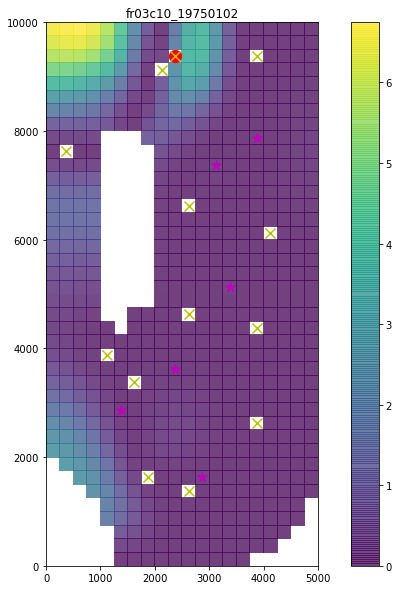

fr03c16_19750102


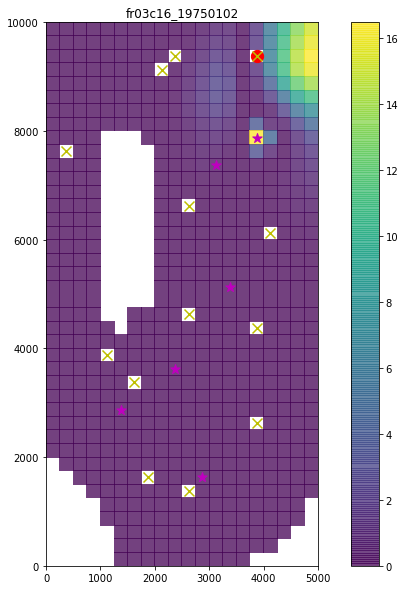

fr04c09_19750102


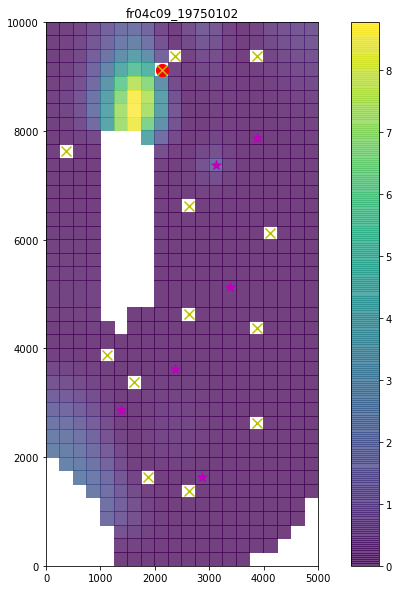

fr10c02_19750102


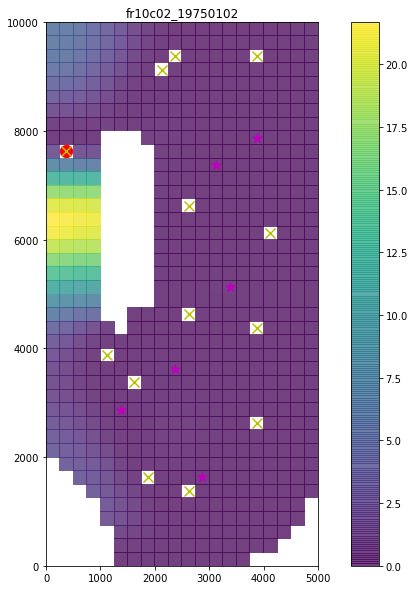

fr14c11_19750102


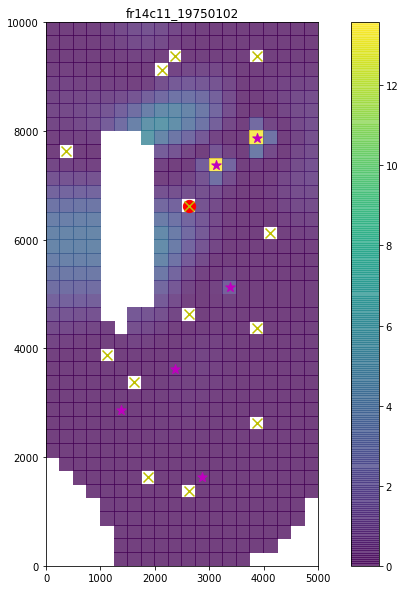

fr16c17_19750102


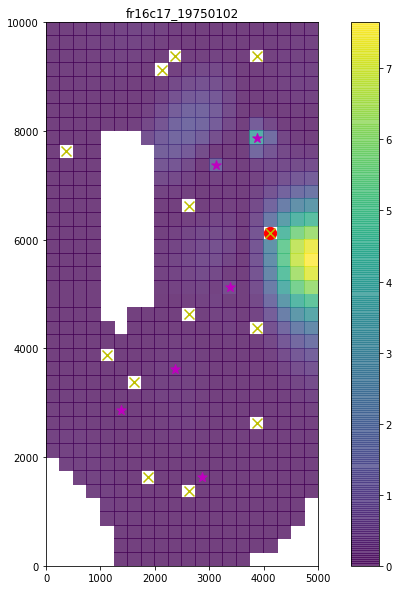

fr22c11_19750102


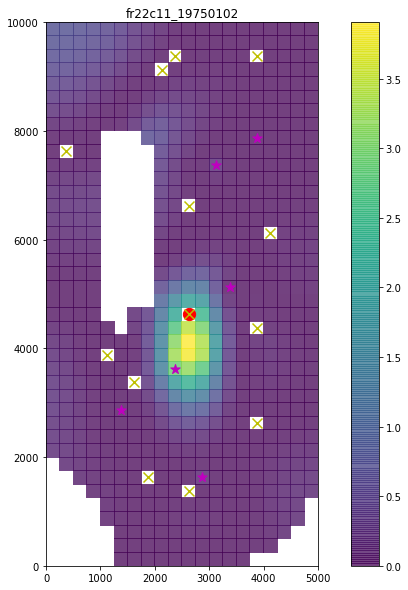

fr23c16_19750102


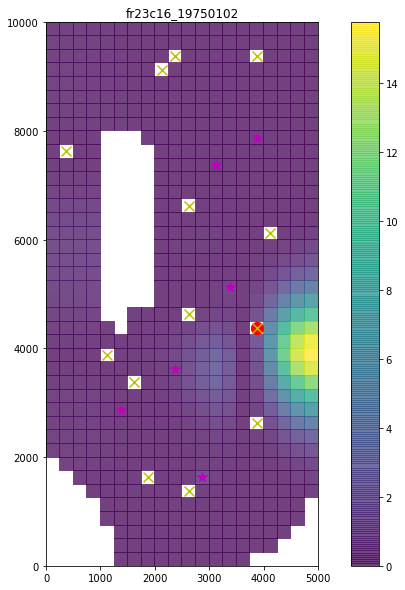

fr25c05_19750102


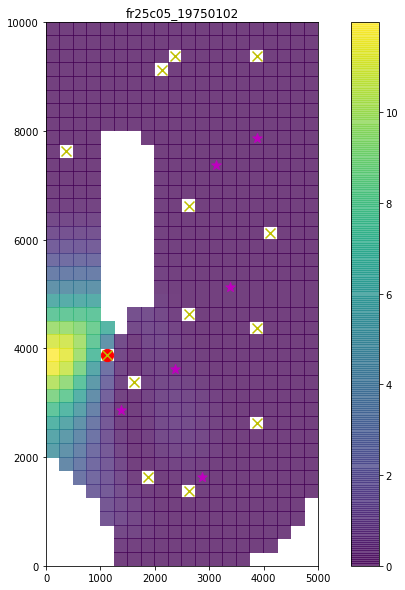

fr27c07_19750102


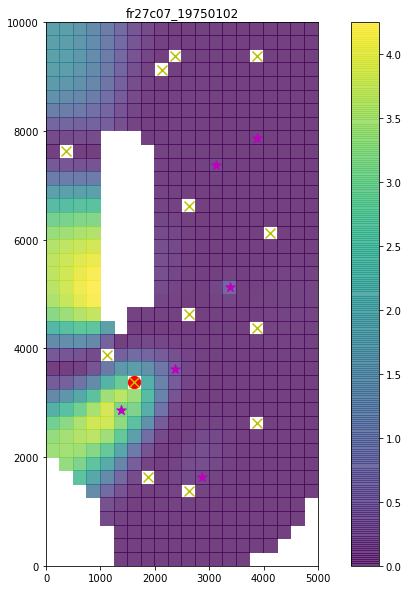

fr30c16_19750102


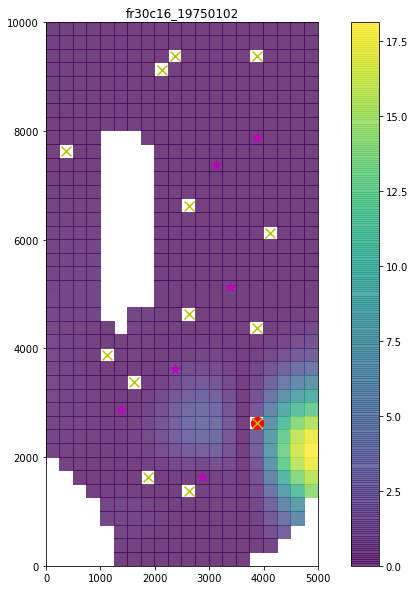

fr34c08_19750102


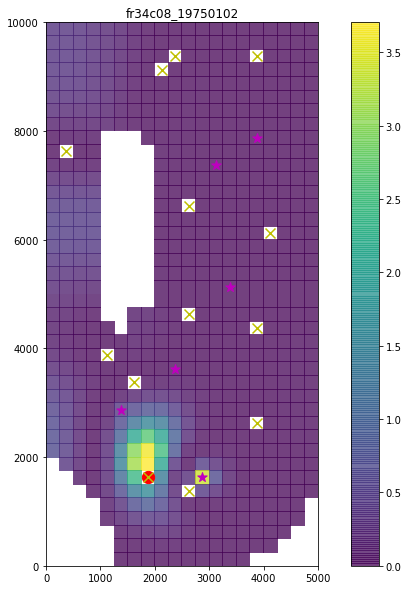

fr35c11_19750102


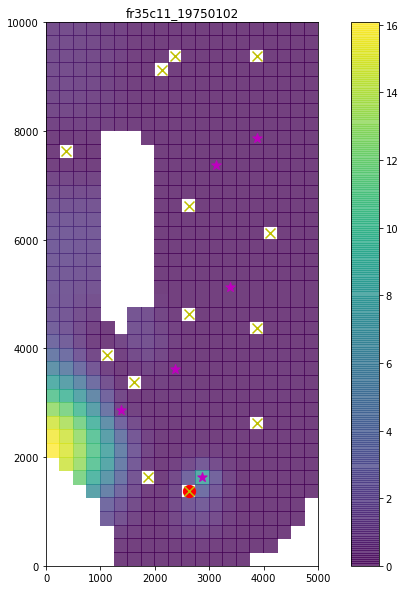

flx_river_l_19750102


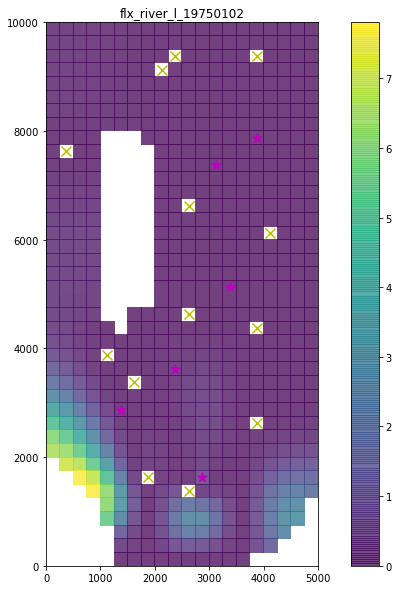

travel_time


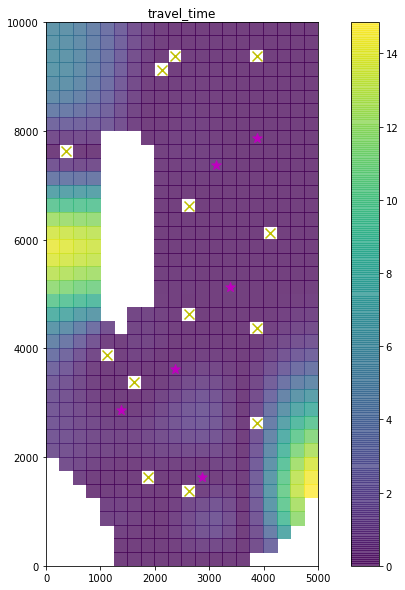

In [28]:
plot_added_worth(df_full)